In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob, os
import rasterio
from datetime import datetime
import pickle
from nansat import Nansat, Domain, NSR

%load_ext autoreload
%autoreload 2

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.libdefor import get_deformation_nodes

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Individual image processing

In [487]:
files = sorted(glob.glob("D:\\Floes\\S1_ground\\*.tif"))
print(len(files))

403


In [472]:
ind1 = 222
ind2 = 223

t1 = datetime.strptime(os.path.basename(files[ind1])[17:-4], "%Y%m%dT%H%M%S")
t2 = datetime.strptime(os.path.basename(files[ind2])[17:-4], "%Y%m%dT%H%M%S")

img = rasterio.open(files[ind1])
print(files[ind1])
a1 = img.read(1)
img.close()

img = rasterio.open(files[ind2])
print(files[ind2])
a2 = img.read(1)
img.close()

# normalize array values
def prepare_array(img):
    # img = (img+1)/(1)
    img -= get_spatial_mean(img)
    img = get_uint8_image(img, None, None, 1, 99)
    return img

a1 = prepare_array(a1)
a2 = prepare_array(a2)

ds = abs(t2-t1).total_seconds()
print("Time difference (seconds): ", ds)

G:\My Drive\Grounded\S1A_EW_GRDM_1SSH_20201013T003648.tif
G:\My Drive\Grounded\S1A_EW_GRDM_1SSH_20201014T011724.tif
VMIN:  -0.24888013970412
VMAX:  0.22489217523147725
VMIN:  -0.2100630039580939
VMAX:  0.17500474487923043
Time difference (seconds):  88836.0


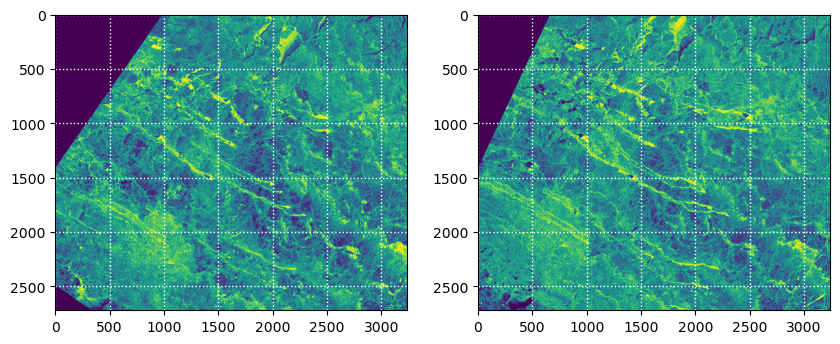

In [473]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(a1, clim=[0, 255])
ax[0].grid(ls = ":", lw = 1, color = "w")
# plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(a2, clim=[0, 255])
ax[1].grid(ls = ":", lw = 1, color = "w")
# plt.colorbar(im1, ax=ax[1])
plt.show()

In [474]:
# Create two Nansat objects with fake georeference (Mercator projection).
# The same georefercne will be use for retrieval of drift.
# True knowledge about georeference of input arrays is prefered.

srs = NSR(32723) 
rows, cols = a1.shape
pixel_size = 50 # meters
d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)

In [475]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.5, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 5.622987508773804
Ratio test 0.500000 found 120 keypoints
MaxDrift filter: 120 -> 120
LSTSQ filter: 120 -> 120


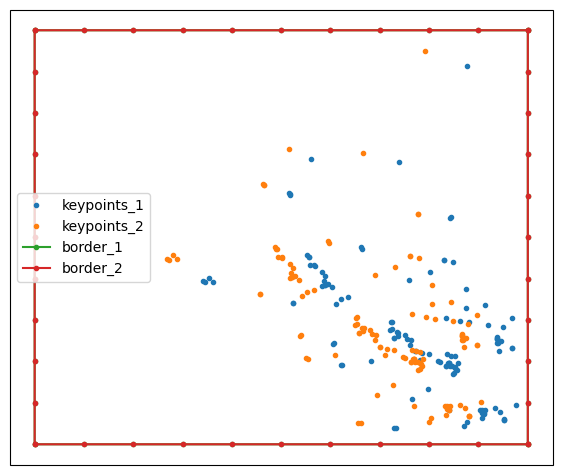

In [476]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()

# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.UTM(zone=23, southern_hemisphere=True))
# ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

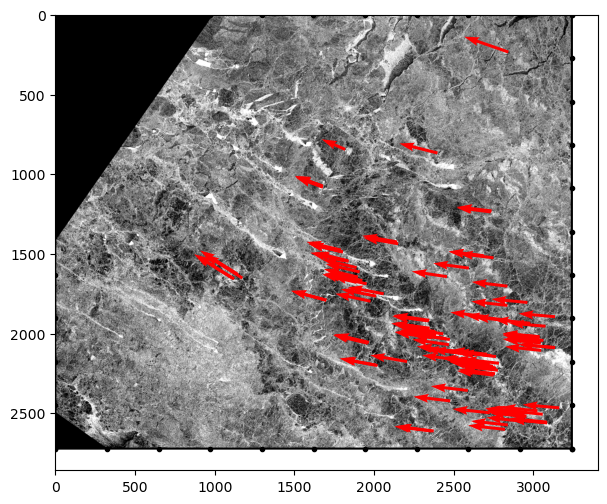

In [477]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=1)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

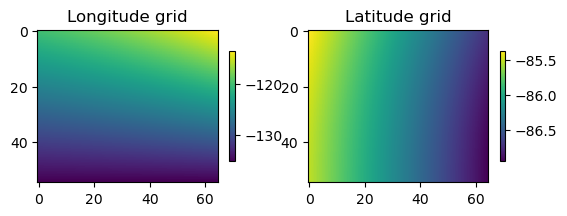

In [478]:
# Create lon/lat grids 

# lon/lat grids in polar stereographic projection covering image_1
pm_step = 50 # lon/lat grids are subsampled
lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

In [479]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs=srs)
# srs.ExportToProj4()

C:\Users\yoko2261\Research\sea_ice_drift\sea_ice_drift\pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


97% 01850.0 02600.0 01631.0 02573.0 -03.0 0.33 3.684
 Pattern matching - OK! (  7 sec)


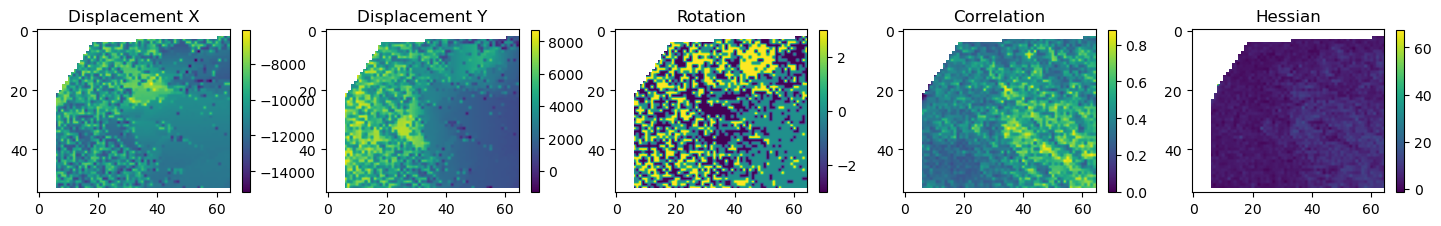

In [480]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i], shrink = 0.7)

plt.show()

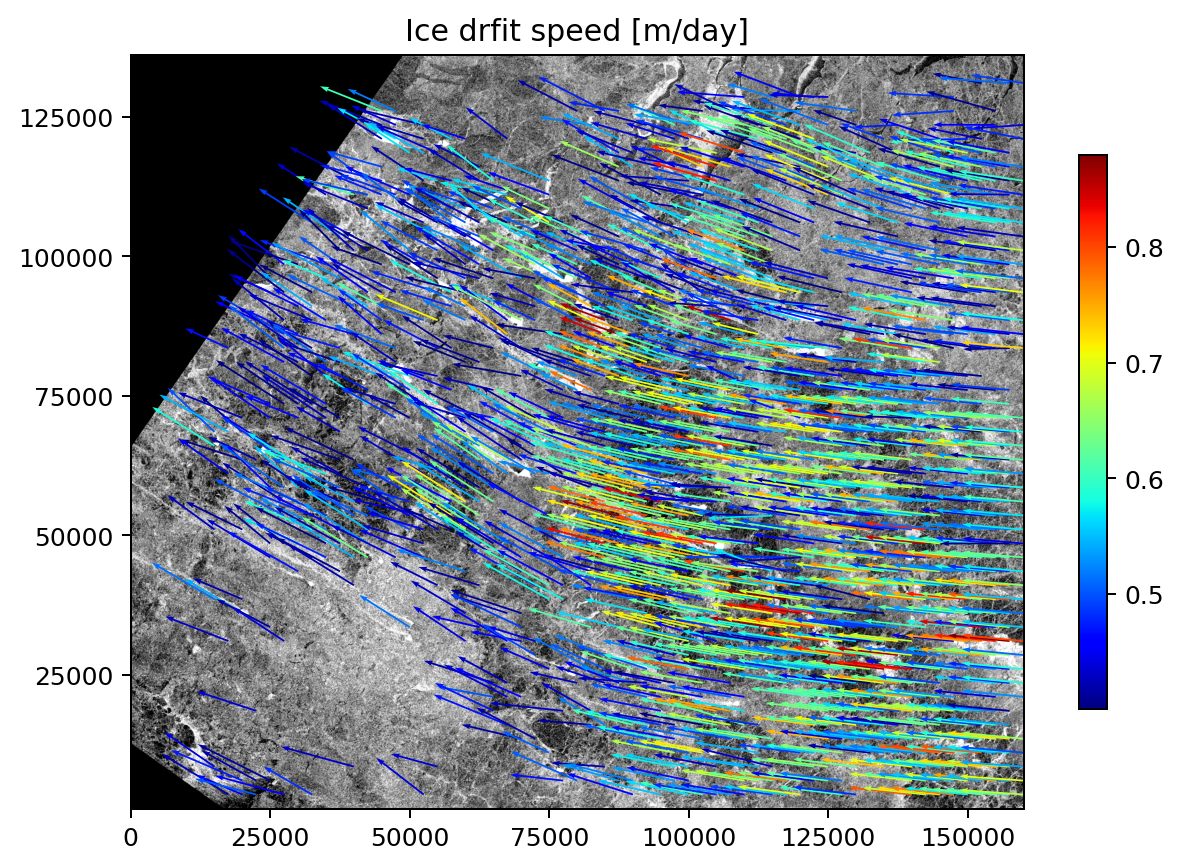

In [486]:
# plot valid vectors in Polar stereographic projection
gpi = (rpm > 0.4) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.UTM(zone=23, southern_hemisphere=True)

plt.figure(figsize=(8,8), dpi = 180)
ax = plt.axes(projection=crs)

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], upm[gpi]/ds*3600*24, vpm[gpi]/ds*3600*24, rpm[gpi],
               cmap='jet', width=0.002, angles='xy', scale_units='xy', scale=1)
plt.colorbar(quiv, shrink=0.5)
# plt.quiverkey(quiv, x1pm.max(), y1pm.max(), 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/day]')
# ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks(np.arange(x1pm.min(), x1pm.max(), 25000))
ax.set_yticks(np.arange(0, y1pm.max(), 25000))

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [15]:
# compute deformation components [1/s], area [m2], perimeter [m], triangulation
e1, e2, e3, a, p, t = get_deformation_nodes(x1pm[gpi], y1pm[gpi], upm[gpi], vpm[gpi])
# create mask for invalid elements (too squeezed or too large)
mask = (np.sqrt(a)/p < 0.15) + (a > 1e8)

# e1 : Mx1 array
#     Divergence, 1/s
# e2 : Mx1 array
#     Shear, 1/s
# e3 : Mx1 array
#     Vorticity, 1/s

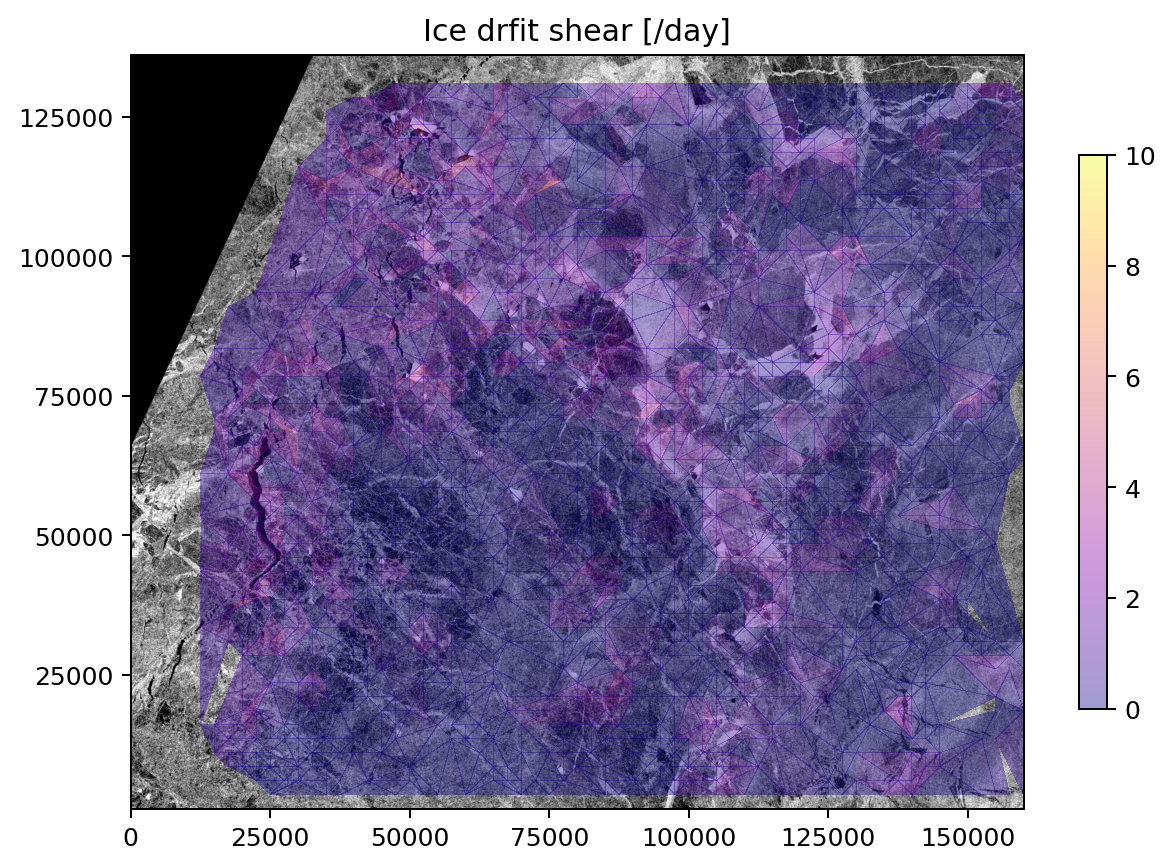

In [468]:
# plot deformation on top of the SAR image

plt.figure(figsize=(8, 8), dpi = 180)
ax = plt.axes(projection=crs)

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
trp = plt.tripcolor(x1pm[gpi], y1pm[gpi], e2*(ds/(3600*24)), triangles=t, vmin=0, vmax=10, cmap='plasma', mask=mask, alpha=0.4)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit shear [/day]')
# ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks(np.arange(x1pm.min(), x1pm.max(), 25000))
ax.set_yticks(np.arange(0, y1pm.max(), 25000))

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

## Summarized version for bulk processing

In [45]:
os.path.basename(files[ind1])[-19:-4]

'20190101T001407'

In [46]:
# normalize array values
def prepare_array(img):
    # img = (img+1)/(1)
    img -= get_spatial_mean(img)
    img = get_uint8_image(img, None, None, 1, 99)
    return img

sub = "W"
files = sorted(glob.glob(f"D:\\Floes\\S1_ground\\S1A_{sub}_*.tif"))
drawing = False
# print(len(files))

for i in range(0, len(files)-1):

    # Image read ==============================================
    ind1 = i
    ind2 = i+1
    
    t1 = datetime.strptime(os.path.basename(files[ind1])[-19:-4], "%Y%m%dT%H%M%S")
    t2 = datetime.strptime(os.path.basename(files[ind2])[-19:-4], "%Y%m%dT%H%M%S")

    t1_str = t1.strftime("%Y%m%dT%H%M%S")
    t2_str = t2.strftime("%Y%m%dT%H%M%S")

    if t2.year >= 2019:
    
        img = rasterio.open(files[ind1])
        # print(files[ind1])
        a1 = img.read(1)
        img.close()
        
        img = rasterio.open(files[ind2])
        # print(files[ind2])
        a2 = img.read(1)
        img.close()        
        
        a1 = prepare_array(a1)
        a2 = prepare_array(a2)
        
        ds = abs(t2-t1).total_seconds()
        print("Time difference (seconds): ", ds)
    
        # Process image =====================================================
        pixel_size = 50 # meters for fake grid
        pm_step = 50 # subsampling for lon/lat grids

        if sub == "EW":
            srs = NSR(32723) #dstCrs = {'init': 'EPSG:32721'}
        elif sub == "W":
            srs = NSR(32721) #dstCrs = {'init': 'EPSG:32721'}
        
        rows, cols = a1.shape
    
        d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
        n1 = Nansat.from_domain(d, a1)
        n2 = Nansat.from_domain(d, a2)
        c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.5, max_drift=20000, verbose=False)
        
        if len(c1) > 10:
            # convert row/column coordinates of matched features to lon/lat
            lon1ft, lat1ft = n1.transform_points(c1, r1)
            lon2ft, lat2ft = n2.transform_points(c2, r2)
            
            # get lon/lat coordinates of the border of images
            lon1b, lat1b = n1.get_border()
            lon2b, lat2b = n2.get_border()
            
            lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
            upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs=srs.ExportToProj4())
        
            ## Draw maps of sea ice velocity ==============================================
            # plot valid vectors in Polar stereographic projection
            gpi = (rpm > 0.4) 
            # X/Y grids in polar stereographic projection covering image_1
            x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)
            
            # spacial reference for plotting
            crs = ccrs.UTM(zone=23, southern_hemisphere=True)

            ### SAVE AS PICKLE =======================================================
            pkl_name = f"D:\\Floes\\ice_vel\\pickle\\S1_{sub}_vel_{t1_str}_{t2_str}.pkl"
            pkl_object = [upm, vpm, apm, rpm, hpm, lon2pm, lat2pm]
            with open(pkl_name, 'wb') as handle:
                pickle.dump(pkl_object, handle)
            print(pkl_name)
            
            ### DRAW MAP of ICE VELOCITY =============================================
            if drawing:
                plt.figure(figsize=(8,8), dpi = 180)
                ax = plt.axes(projection=crs)
        
                normz = Normalize(vmin = 0.2, vmax = 0.9)
                
                ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', vmin = 100, vmax = 250)
                quiv=ax.quiver(x1pm[gpi], y1pm[gpi], upm[gpi]/ds*3600*24, vpm[gpi]/ds*3600*24, rpm[gpi],
                               cmap='jet', width=0.002, angles='xy', scale_units='xy', scale=1, norm = normz)
                plt.colorbar(quiv, shrink=0.5)
                # plt.quiverkey(quiv, x1pm.max(), y1pm.max(), 0.05, '0.05 m/s', coordinates='data')
                plt.title('Ice drfit speed [m/day]')
                # ax.add_feature(land_50m, edgecolor='black')
                ax.set_xticks(np.arange(x1pm.min(), x1pm.max(), 25000))
                ax.set_yticks(np.arange(0, y1pm.max(), 25000))
                
                ax.set_xlim([x1pm.min() - pixel_size*pm_step, x1pm.max() + pixel_size*pm_step])
                ax.set_ylim([y1pm.min() - pixel_size*pm_step, x1pm.max() + pixel_size*pm_step, y1pm.max()])
                
                # plt.show()            
                imgname = f"D:\\Floes\\ice_vel\\maps\\S1_{sub}_vel_{t1_str}_{t2_str}.png"
                print(imgname)
                plt.savefig(imgname, bbox_inches = "tight")
                plt.close()
            
print("Done")

Time difference (seconds):  112075.0
98% 00100.0 02650.0 00099.0 02649.0 +00.0 0.70 13.92
 Pattern matching - OK! (  7 sec)
D:\Floes\ice_vel\pickle\S1_W_vel_20190101T001407_20190102T072202.pkl
Time difference (seconds):  148596.0
Time difference (seconds):  171814.0
Time difference (seconds):  85873.0
99% 00600.0 02650.0 00605.0 02632.0 -03.0 0.29 5.921
 Pattern matching - OK! (  6 sec)
D:\Floes\ice_vel\pickle\S1_W_vel_20190106T002212_20190107T001325.pkl
Time difference (seconds):  174798.0
97% 01700.0 02600.0 01676.0 02560.0 +00.0 0.32 6.170
 Pattern matching - OK! (  6 sec)
D:\Floes\ice_vel\pickle\S1_W_vel_20190107T001325_20190109T004643.pkl
Time difference (seconds):  23227.0
98% 00400.0 02500.0 00359.0 02575.0 +03.0 0.34 3.876
 Pattern matching - OK! (  7 sec)
D:\Floes\ice_vel\pickle\S1_W_vel_20190109T004643_20190109T071350.pkl
Time difference (seconds):  320416.0
Time difference (seconds):  112075.0
Time difference (seconds):  62631.0
96% 00850.0 02600.0 00776.0 02601.0 -03.0 0.23

In [23]:
files = glob.glob(f"D:\\Floes\\ice_vel\\maps\\S1*.png")
for f in files:
    os.rename(f, f.replace("S1_", "S1_EW_"))

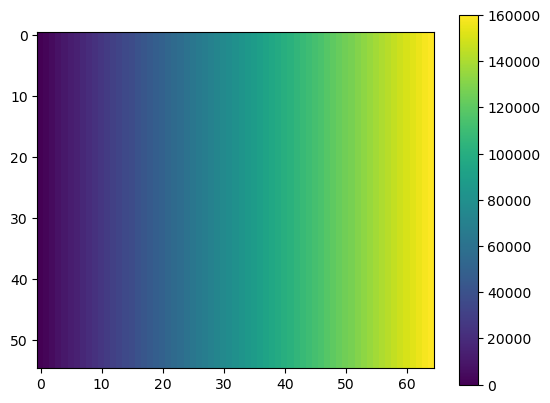

In [19]:
plt.imshow(x1pm)
plt.colorbar()

In [20]:
x1pm.shape, upm.shape

((55, 65), (55, 65))

In [ ]:
srs = NSR(3395) # fake projection
pixel_size = 100 # meters for fake grid
pm_step = 30 # subsampling for lon/lat grids

a1 = np.load('S1B_EW_GRDM_1SDH_20200123T120618.npy')
a2 = np.load('S1B_EW_GRDM_1SDH_20200125T114955.npy')
a1 = prepare_array(a1)
a2 = prepare_array(a2)

rows, cols = a1.shape
d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=10000, verbose=True)

lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs=srs.ExportToProj4())

In [ ]:
## Generate test files for drift_from_arrays.py
"""
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = 'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE'
f2 = 'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'

n1 = Nansat(f1)
n2 = Nansat(f2)

# projection (https://epsg.io/3413)
srs = NSR(3413)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 500 m
d = Domain(srs.wkt, '-te %f %f %f %f -tr 100 100' % (
    n1x.mean()-100000,
    n1y.mean()-100000,
    n1x.mean()+100000,
    n1y.mean()+100000))

n1.resize(0.5)
s0hh = n1['sigma0_HH']
n1b = Nansat.from_domain(n1, s0hh)
n1b.reproject_gcps()
n1b.vrt.tps = True
n1b.reproject(d)
s0hh1_pro = n1b[1]

n2.resize(0.5)
s0hh = n2['sigma0_HH']
n2b = Nansat.from_domain(n2, s0hh)
n2b.reproject_gcps()
n2b.vrt.tps = True
n2b.reproject(d)
s0hh2_pro = n2b[1]

np.save('S1B_EW_GRDM_1SDH_20200123T120618', s0hh1_pro)
np.save('S1B_EW_GRDM_1SDH_20200125T114955', s0hh2_pro)
#"""